In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import time

In [5]:
class LandScape():

    def __init__(self, N, K, K_within, K_between, state_num=2):
        self.N = N
        self.K = K
        self.K_within = K_within
        self.K_between = K_between
        
        self.IM_np = None
        self.state_num = state_num
        self.FC_np = None
        self.cache_np = [] # (1*2^N), using int(str) as the index
        self.cog_cache_np = [0] * (2**self.N)

    def create_influence_matrix(self):
        IM = np.eye(self.N)
        if self.K_within is None:
            for i in range(self.N):
                probs = [1 / (self.N - 1)] * i + [0] + [1 / (self.N - 1)] * (self.N - 1 - i)
                ids = np.random.choice(self.N, self.K, p=probs, replace=False)
                for index in ids:
                    IM[i][index] = 1
        else:
            for i in range(self.N):
                if i // (self.N // 2) < 1:
                    within = [j for j in range(self.N // 2)]
                    between = [j for j in range(self.N // 2, self.N)]
                    probs = [1 / (self.N // 2 - 1)] * i + [0] + [1 / (self.N // 2 - 1)] * (self.N // 2 - 1 - i)
                    ids_within = np.random.choice(within, self.K_within, p=probs, replace=False)
                    ids_between = np.random.choice(between, self.K_between, replace=False)
                    for index in ids_within:
                        IM[i][index] = 1
                    for index in ids_between:
                        IM[i][index] = 1

                else:
                    within = [j for j in range(self.N // 2, self.N)]
                    between = [j for j in range(self.N // 2)]
                    probs = [1 / (self.N // 2 - 1)] * (i - self.N // 2) + [0] + [1 / (self.N // 2 - 1)] * (
                                self.N - 1 - i)
                    ids_between = np.random.choice(between, self.K_between, replace=False)
                    ids_within = np.random.choice(within, self.K_within, p=probs, replace=False)
                    for index in ids_within:
                        IM[i][index] = 1
                    for index in ids_between:
                        IM[i][index] = 1
        self.IM_np = np.array(IM)
    
    def create_fitness_config_np(self,):
        self.FC_np = np.random.random((self.N, pow(self.state_num, self.K+1))) # (N by 2^(K+1))
    
    def calculate_fitness_np(self, state):
#         state = np.array(state)
        state = np.tile(state, (self.N, 1))
        index_matrix = state[self.IM_np.astype("bool")].reshape(self.N, -1)
        index_matrix = index_matrix.dot(self.state_num ** np.arange(index_matrix.shape[1])[::-1])
        res = np.average(self.FC_np[np.arange(self.N), index_matrix])
        return res
    
    def store_cache_np(self,):
#         self.cache_np = [self.calculate_fitness_np(each_state) for each_state in product(range(self.state_num), repeat=self.N)]
        all_states = [i for i in product(range(self.state_num), repeat=self.N)]
        for each_state in all_states:
            self.cache_np.append(self.calculate_fitness_np(each_state))
    
    def initialize(self, first_time=True, norm=True):
        if first_time:
            self.create_influence_matrix()
        self.create_fitness_config_np()
        self.store_cache_np()
        if norm:
            max_ = max(self.cache_np)
            min_ = min(self.cache_np)
            self.cache_np = [(i-min_)/(max_-min_) for i in self.cache_np]
        self.cog_cache_np = {}
    
    def query_fitness_np(self, state):
#         state = np.array(state)
        state_index = state.dot(2 ** np.arange(state.size)[::-1])
        return self.cache_np[state_index]

In [8]:
class Agent:
    
    def __init__(self, N, landscape):
        self.N = N
        self.state = np.random.choice([0, 1], self.N)
        self.landscape = landscape
        self.fitness = self.landscape.query_fitness_np(self.state)
    
    def search(self, ):
        next_state = self.state.copy()
        next_index = np.random.choice(self.N)
        next_state[next_index] ^= 1
        if self.landscape.query_fitness_np(self.state) < self.landscape.query_fitness_np(next_state):
            self.state = next_state
            self.fitness = self.landscape.query_fitness_np(self.state)


00:00:04


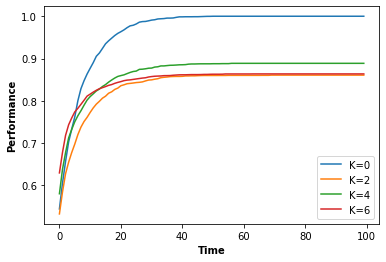

In [9]:
t0 = time.time()
np.random.seed(100)
gap_list = []
ress = []

N = 8
agent_num = 100
search_iteration = 100
landscape_repeat = 5
K_list = [0, 2, 4, 6]
performance_across_para = []
for K in K_list:  # key parameter for complexity
    performance_one_para = []
    agents_performance = []
    for i in range(landscape_repeat):  # landscape repetitions
        landscape = LandScape(N, K, None, None)
        landscape.initialize(norm=True)
        crowd = []
        for _ in range(agent_num):
            agent = Agent(N, landscape)
            crowd.append(agent)
        for agent in crowd:  # agent repetitions
            agent_performance = []
            for _ in range(search_iteration):
                agent.search()
                agent_performance.append(agent.fitness)
            agents_performance.append(agent_performance)

    for period in range(search_iteration):
        temp = [agent_performance[period] for agent_performance in agents_performance]
        performance_one_para.append(sum(temp) / len(temp))
    performance_across_para.append(performance_one_para)

x = range(search_iteration)
for index, K in enumerate(K_list):
    plt.plot(x, performance_across_para[index], label="K={0}".format(K))
plt.xlabel('Time', fontweight='bold', fontsize=10)
plt.ylabel('Performance', fontweight='bold', fontsize=10)
# plt.xticks(x)
plt.legend()
# plt.savefig("\Performance_across_K.png", transparent=False, dpi=200)
t1 = time.time()
print(time.strftime("%H:%M:%S", time.gmtime(t1-t0)))